# Training Landmark Image Classifier Without Transfer Learning

In this notebook, I use a randon search approach to test out a variety of hyperparameters to train a CNN from scratch.

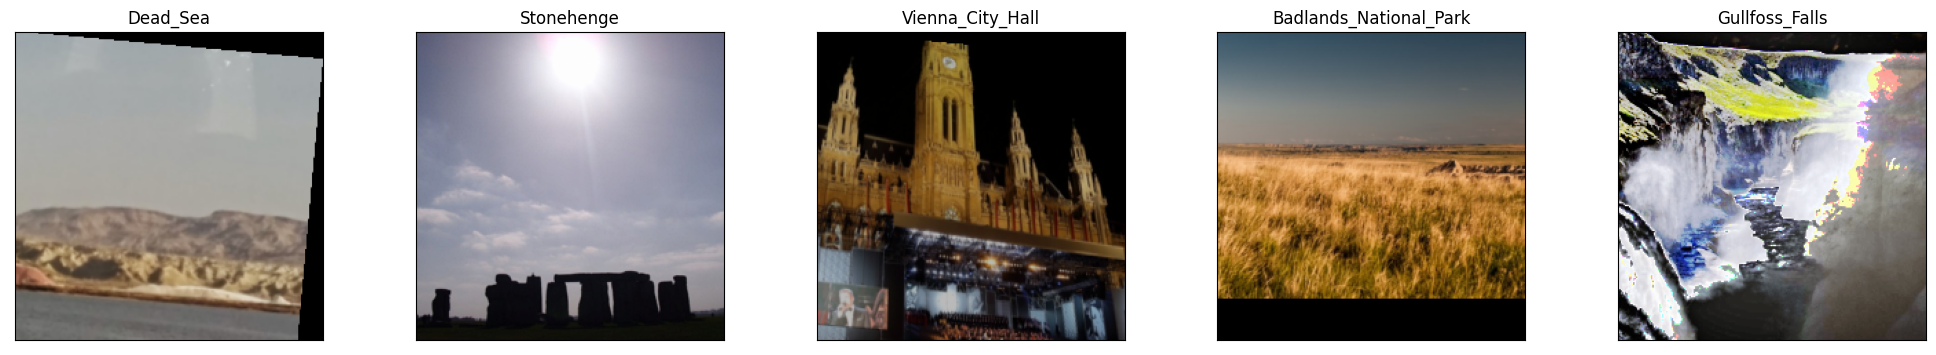

In [1]:
# Visualize a small sample to make sure everything looks right before we start training.

%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

data_loaders = get_data_loaders()
visualize_one_batch(data_loaders)

## Training the model

In [2]:
# Set up some basic parameters for our training.
valid_size = 0.2
num_epochs = 75
num_classes = 50

In [3]:
# Import needed modules and our model/training functions.
import numpy as np
import mlflow
from random import choices

from src.train import optimize
from src.optimization import get_optimizer, get_loss

Delete all previous run throughs as I'd only start from here again if I made fundamental changes to the network. Also, the GPU-space I am running on has limited disk space and these can get quite large.

In [4]:
# Find any previous runs from previous run-throughs and deletes them.
runs = mlflow.search_runs()
print(f'Found {len(runs)} existing runs from previous testing.')
for i, run in runs.iterrows():
    mlflow.delete_run(run['run_id'])

# Permanently deletes from the disk space our deleted runs.
!mlflow gc

Found 0 existing runs from previous testing.


In [5]:
def train_model_once(batch_size, dropout, opt, learning_rate, weight_decay):
    data_loaders = get_data_loaders(batch_size, valid_size)
    model = MyModel(num_classes, dropout)
    optimizer = get_optimizer(model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay)
    loss = get_loss()

    with mlflow.start_run():
        mlflow.log_params({
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "dropout": dropout,
            "weight_decay": weight_decay,
            "optimizer": opt,
        })

        optimize(
            data_loaders,
            model,
            optimizer,
            loss,
            n_epochs=num_epochs,
            save_path="checkpoints/best_val_loss.pt"
        )

        # Restore best validation loss
        model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

        # Test model on *validation* set
        val_loss, val_accuracy = one_epoch_test(data_loaders['valid'], model, loss)

        mlflow.log_metric("val_loss", val_loss)
        mlflow.log_metric("val_accuracy", val_accuracy)

        mlflow.log_artifact('checkpoints/best_val_loss.pt')

In [6]:
n_grid = 15

# Sample different batch sizes.
batches = choices([8, 16, 32, 64], k=n_grid)

# Sample different learning rate values.
lrs = [n * 1e-5 for n in np.random.uniform(1, 500, n_grid)]

# Sample different dropout values.
dropouts = [n * 1e-1 for n in np.random.randint(1, 6, n_grid)]

# Sample different weight decay values.
decays = [n * 1e-5 for n in np.random.uniform(1, 100, n_grid)]

# Sample different optimizers.
opts = choices(['sgd', 'adam'], k=n_grid)

print(batches, opts, lrs, dropouts, decays)

[32, 32, 16, 16, 16, 32, 64, 64, 64, 32, 16, 64, 16, 16, 32] ['adam', 'adam', 'sgd', 'adam', 'adam', 'sgd', 'adam', 'adam', 'adam', 'adam', 'adam', 'sgd', 'adam', 'sgd', 'adam'] [3.90303071073026e-05, 0.0007320302843951958, 0.001172159095675568, 0.0005057944529968117, 0.0025895318327401927, 0.0008087065218342068, 0.0015815266563099705, 0.0025949256407559337, 0.00467105505625113, 0.002921516182666107, 0.003962168747564676, 0.001926846926030054, 0.0012036473039348406, 0.000924998226289161, 0.0012846411568773095] [0.30000000000000004, 0.1, 0.5, 0.5, 0.5, 0.30000000000000004, 0.5, 0.1, 0.4, 0.30000000000000004, 0.5, 0.4, 0.30000000000000004, 0.4, 0.2] [0.00043654242326550917, 0.0005435025327953529, 0.0005691191448168684, 0.000795764017408755, 0.0007284730677839056, 5.5635559683080634e-05, 7.086995292300616e-05, 0.0004743998878164624, 0.0005284206947043578, 0.00071736662988675, 0.000898681070507227, 0.0007732279116312108, 0.0009138959712611459, 0.0002428480202735297, 0.00021879585708869294]

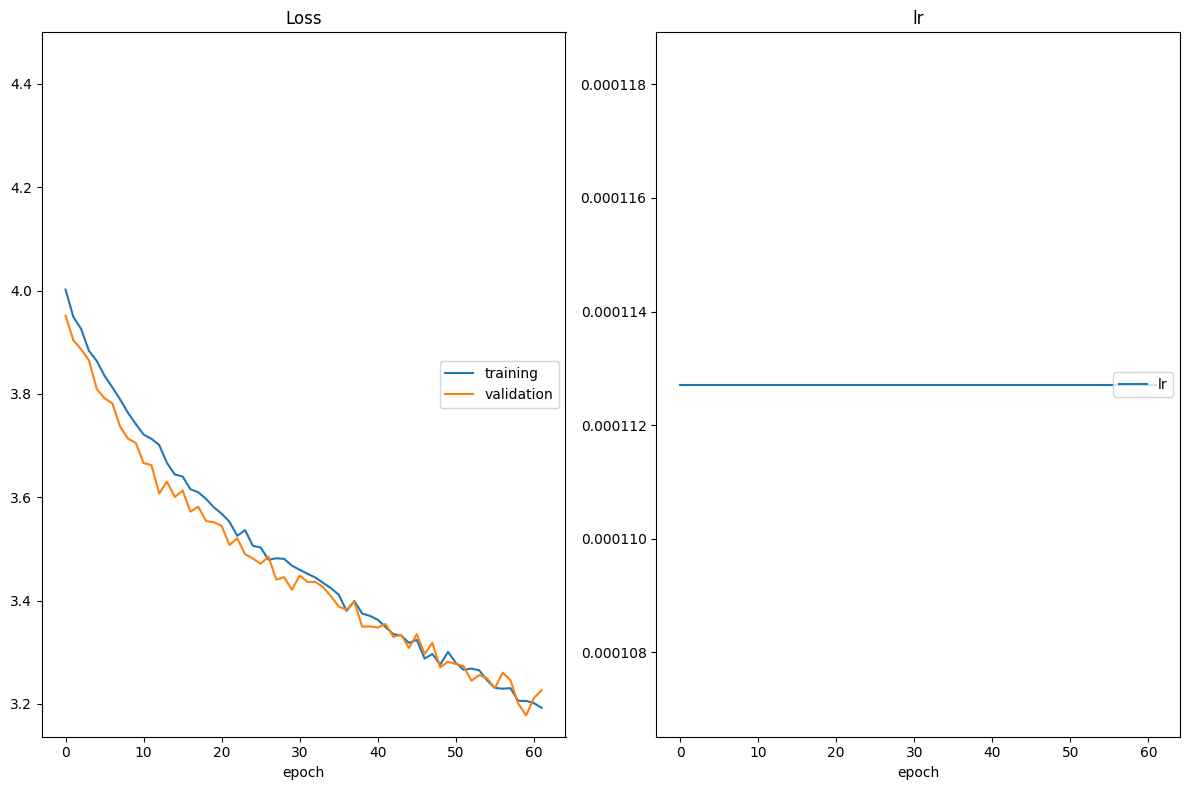

Training:  53%|████████████████▌              | 267/500 [00:12<00:10, 21.48it/s]

In [ ]:
for batch, dropout, opt, lr, decay in zip(batches, dropouts, opts, lrs, decays):
    train_model_once(batch, dropout, opt, lr, decay)

In [5]:
mlflow_client = mlflow.MlflowClient()
runs = mlflow.search_runs()

# Add column for number of epochs we achieved in run before stopping early.
runs['total_epochs'] = runs.apply(lambda row: len(mlflow_client.get_metric_history(row['run_id'], 'epoch_valid_loss')), axis=1)

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 880, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 691, in _get_run_info_from_dir
    meta = FileStore._read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 1239, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/store/tracking/file_store.py", line 1232, in _read_helper
    result = read_yaml(root, file_name)
  File "/usr/local/lib/python3.9/dist-packages/mlflow/utils/file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/notebooks/mlruns/0/.ipynb_checkpoints/meta.ya

In [6]:
# Review any runs that ended early to see if I want to adjust any parameters.
runs[runs['total_epochs'] < num_epochs].head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val_accuracy,metrics.epoch_lr,metrics.epoch_train_loss,metrics.epoch_valid_loss,...,params.batch_size,params.dropout,params.learning_rate,params.optimizer,params.weight_decay,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.source.name,total_epochs
0,ef986a9d9df1401e8e57d5ec132b5c3c,0,FINISHED,file:///notebooks/mlruns/0/ef986a9d9df1401e8e5...,2023-06-15 03:59:27.674000+00:00,2023-06-15 04:16:33.636000+00:00,34.099998,0.000459,2.635659,2.755379,...,32,0.4,0.0009173065863634322,adam,0.0005002251410101575,root,LOCAL,big-pig-650,/usr/local/lib/python3.9/dist-packages/ipykern...,56
1,7df6d680ef0c4e5abf298326bc97d5e4,0,FINISHED,file:///notebooks/mlruns/0/7df6d680ef0c4e5abf2...,2023-06-15 03:22:41.703000+00:00,2023-06-15 03:59:26.859000+00:00,29.600000,0.001070,3.152550,3.187714,...,8,0.30000000000000004,0.001069572162284598,adam,0.00013081785249633105,root,LOCAL,indecisive-sheep-959,/usr/local/lib/python3.9/dist-packages/ipykern...,63
2,e53934cd2699494fad692cd3485f27b2,0,FINISHED,file:///notebooks/mlruns/0/e53934cd2699494fad6...,2023-06-15 02:52:38.062000+00:00,2023-06-15 03:22:40.901000+00:00,40.799999,0.000520,2.627506,2.784080,...,8,0.4,0.004163888777594105,sgd,0.0004457509688022053,root,LOCAL,monumental-dog-686,/usr/local/lib/python3.9/dist-packages/ipykern...,68
3,2e81247984c44292ae7e7e331aa8ec84,0,FINISHED,file:///notebooks/mlruns/0/2e81247984c44292ae7...,2023-06-15 02:33:00.272000+00:00,2023-06-15 02:52:37.240000+00:00,37.099998,0.002425,2.469537,2.775798,...,32,0.4,0.004849850162288352,sgd,0.0006873906962470354,root,LOCAL,nervous-crane-379,/usr/local/lib/python3.9/dist-packages/ipykern...,73
4,abaae36244c243f0959072ed66b6ecb6,0,FINISHED,file:///notebooks/mlruns/0/abaae36244c243f0959...,2023-06-15 02:01:39.122000+00:00,2023-06-15 02:32:59.454000+00:00,26.100000,0.000113,3.132490,3.162635,...,8,0.2,0.00011271662653605422,sgd,0.00010669539286632005,root,LOCAL,rogue-rat-854,/usr/local/lib/python3.9/dist-packages/ipykern...,71


In [7]:
sorted_runs = runs.sort_values(by='metrics.val_loss')[[
    'run_id',
    'status',
    'start_time',
    'end_time',
    'metrics.epoch_train_loss',
    'metrics.epoch_lr',
    'metrics.epoch_valid_loss',
    'metrics.val_loss',
    'metrics.val_accuracy',
    'params.batch_size',
    'params.learning_rate',
    'params.optimizer',
    'params.weight_decay',
    'params.dropout',
    'total_epochs']]
sorted_runs.head(15)

,run_id,status,start_time,end_time,metrics.epoch_train_loss,metrics.epoch_lr,metrics.epoch_valid_loss,metrics.val_loss,metrics.val_accuracy,params.batch_size,params.learning_rate,params.optimizer,params.weight_decay,params.dropout,total_epochs
8,ad7467addf924e0a86b3f6b8163cd0f6,FINISHED,2023-06-15 00:29:32.752000+00:00,2023-06-15 00:44:59.082000+00:00,0.318540,0.000037,1.913420,1.748827,56.400002,64,0.0002998372247193153,adam,0.0009493966818808,0.1,56
13,d16a317b378c484cbe6f8fde894a75f8,FINISHED,2023-06-14 22:41:28.720000+00:00,2023-06-14 23:06:19.482000+00:00,0.800191,0.001189,2.358978,1.932160,54.000000,8,0.004754064388985482,sgd,0.0005964904231734222,0.1,56
6,7a79b3ac3b7045c489851a5aa0754f96,FINISHED,2023-06-15 01:08:29.759000+00:00,2023-06-15 01:30:50.442000+00:00,1.943834,0.000752,2.525495,2.080491,47.299999,16,0.003009563908598612,sgd,0.0008103133746352966,0.30000000000000004,69
7,15d81d29142847af8b773a76bd47adbc,FINISHED,2023-06-15 00:45:00.942000+00:00,2023-06-15 01:08:28.944000+00:00,0.869744,0.001083,2.441354,2.085474,48.500000,8,0.004332218967416927,sgd,0.0009659757127438138,0.1,53
9,0babc7a7f2654c23becf02e2f813b137,FINISHED,2023-06-15 00:09:56.672000+00:00,2023-06-15 00:29:31.934000+00:00,2.339586,0.000788,2.663500,2.238314,42.099998,32,0.0007884126564776514,adam,7.440107705542673e-05,0.4,64
2,e53934cd2699494fad692cd3485f27b2,FINISHED,2023-06-15 02:52:38.062000+00:00,2023-06-15 03:22:40.901000+00:00,2.627506,0.000520,2.784080,2.290801,40.799999,8,0.004163888777594105,sgd,0.0004457509688022053,0.4,68
3,2e81247984c44292ae7e7e331aa8ec84,FINISHED,2023-06-15 02:33:00.272000+00:00,2023-06-15 02:52:37.240000+00:00,2.469537,0.002425,2.775798,2.450189,37.099998,32,0.004849850162288352,sgd,0.0006873906962470354,0.4,73
0,ef986a9d9df1401e8e57d5ec132b5c3c,FINISHED,2023-06-15 03:59:27.674000+00:00,2023-06-15 04:16:33.636000+00:00,2.635659,0.000459,2.755379,2.455421,34.099998,32,0.0009173065863634322,adam,0.0005002251410101575,0.4,56
14,a2d3f8c29b53487cb7dce7d18838578b,FINISHED,2023-06-14 22:24:25.627000+00:00,2023-06-14 22:41:27.888000+00:00,2.959593,0.000235,3.052731,2.775792,28.799999,32,0.0018789551930483391,adam,0.0005190920940294755,0.5,56
1,7df6d680ef0c4e5abf298326bc97d5e4,FINISHED,2023-06-15 03:22:41.703000+00:00,2023-06-15 03:59:26.859000+00:00,3.152550,0.001070,3.187714,2.842515,29.600000,8,0.001069572162284598,adam,0.00013081785249633105,0.30000000000000004,63


In [8]:
lowest_loss_id = sorted_runs.iloc[0]['run_id']

# Fetch the best model from that run and store it in our checkpoints for use during testing.
mlflow.artifacts.download_artifacts(run_id=lowest_loss_id, artifact_path='best_val_loss.pt', dst_path='./checkpoints')

'/notebooks/checkpoints/best_val_loss.pt'

## Testing the final model

In [7]:
# Load the model that got the best validation accuracy and do a run using our test set.
import torch

from src.helpers import get_device
from src.train import one_epoch_test
from src.model import MyModel

print(get_device())
model = MyModel(num_classes=num_classes)
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt', map_location=get_device()))

# Run test
one_epoch_test(data_loaders['test'], model, get_loss())

cpu


Testing: 100%|██████████████████████████████████| 40/40 [01:56<00:00,  2.90s/it]

Test Loss: 1.631462


Test Accuracy: 59% (743/1250)


(1.6314623646438122, tensor(59.4400))

## Prepare our production model

In the event we use this model, we will go ahead and create the version we will use for inference. This will be a class that wraps our model.

In [8]:
from src.production import Predictor
from src.data import get_data_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

model = MyModel(num_classes=num_classes).cpu()
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt', map_location='cpu'))

# Let's wrap our model using the predictor class
mean, std = get_data_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/original_exported.pt")

Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [10]:
# Load using torch.jit.load
model_reloaded =  torch.jit.load("checkpoints/original_exported.pt")

In [15]:
from src.production import predictor_test

pred, truth = predictor_test(model_reloaded)

  0%|                                          | 1/1250 [00:00<08:50,  2.35it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %370 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
100%|███████████████████████████████████████| 1250/1250 [03:33<00:00,  5.84it/s]

Accuracy: 0.58
